# Unofficial Walkthrough of Vision Transformer

Hiroto Honda  [homepage](https://hirotomusiker.github.io/)  

<a href="http://colab.research.google.com/github/hirotomusiker/schwert_colab_data_storage/blob/master/notebook/Vision_Transformer_Tutorial.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>  

This notebook provides the simple walkthrough of the Vision Transformer. We hope you will be able to understand how it works by looking at the actual data flow during inference.  

credits:
- Paper: Alexey Dosovitskiy et al., "An Image Is Worth 16x16 Words: Transformers for Image Recognition at Scale",
https://arxiv.org/abs/2010.11929
- Model Implementation: this notebook loads (and is inspired by) Ross Wightman (@wightmanr)'s amazing module: https://github.com/rwightman/pytorch-image-models/tree/master/timm . For the detailed codes, please refer to the repo.
- The copyright of figures and demo images belongs to Hiroto Honda.



# Preparation

In [1]:
%%capture
!pip install timm

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

# Prepare Model and Data

In [3]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [4]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [5]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference

In [6]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
church, church_building



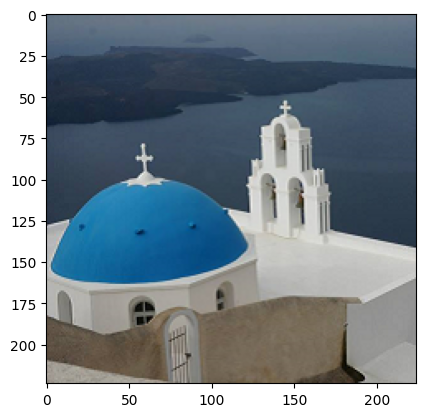

In [7]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Figure 1. Vision Transformer inference pipeline.  
1. Split Image into Patches  
The input image is split into 14 x 14 vectors with dimension of 768 by Conv2d (k=16x16) with stride=(16, 16).
2. Add Position Embeddings  
Learnable position embedding vectors are added to the patch embedding vectors and fed to the transformer encoder.
3. Transformer Encoder  
The embedding vectors are encoded by the transformer encoder. The dimension of input and output vectors are the same. Details of the encoder are depicted in Fig. 2.
4. MLP (Classification) Head  
The 0th output from the encoder is fed to the MLP head for classification to output the final classification results.


# 1. Split Image into Patches

The input image is split into N patches (N = 14 x 14 for ViT-Base)
and converted to D=768 embedding vectors by learnable 2D convolution:
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [8]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


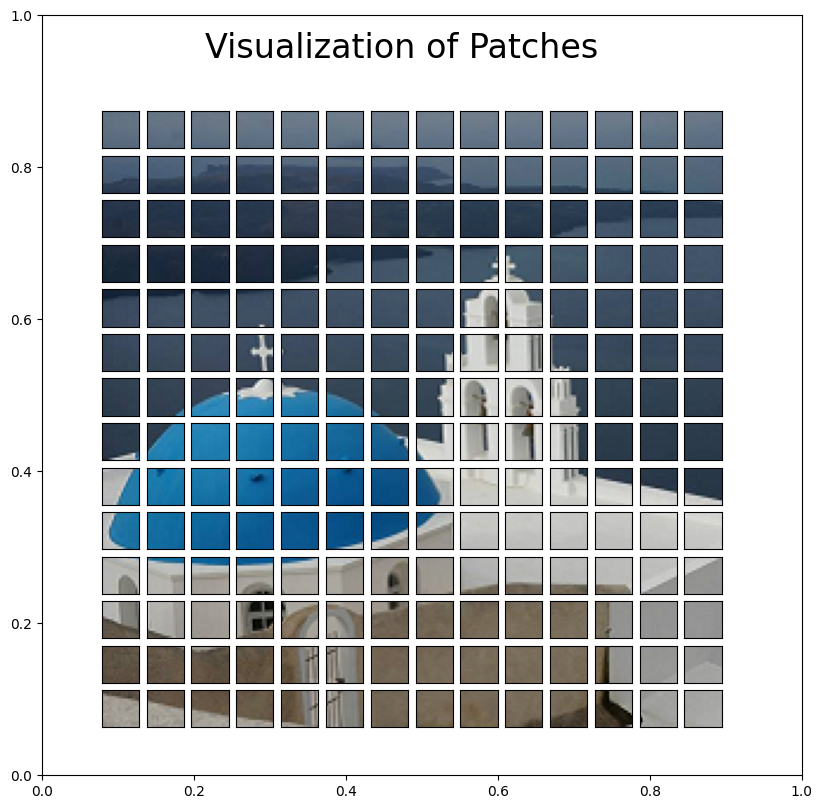

In [11]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d
# with stride=(16, 16) shown above.

# Define the rect variable for axes
rect = [0.05, 0.05, 0.95, 0.95]
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
fig.add_axes(rect)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Add Position Embeddings
To make patches position-aware, learnable 'position embedding' vectors are added to the patch embedding vectors. The position embedding vectors learn distance within the image thus neighboring ones have high similarity.

### Visualization of position embeddings

In [12]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


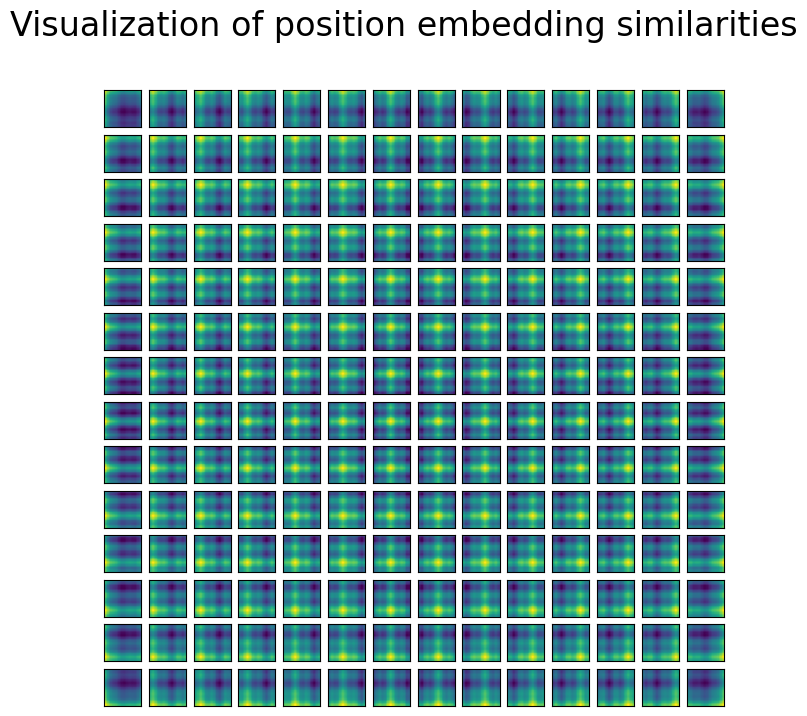

In [13]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
A learnable class token is prepended to the patch embedding vectors as the 0th vector.  
197 (1 + 14 x 14) learnable position embedding vectors are added to the patch embedding vectors.

In [15]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Figure 2. Detailed schematic of Transformer Encoder.
- N (=197) embedded vectors are fed to the L (=12) series encoders.
- The vectors are divided into query, key and value after expanded by an fc layer.
- q, k and v are further divided into H (=12) and fed to the parallel attention heads.
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).

Implementation Reference:

- [tensorflow implementation](https://github.com/google-research/vision_transformer/blob/502746cb287a107f9911c061f9d9c2c0159c81cc/vit_jax/models.py#L62-L146)
- [pytorch implementation (timm)](https://github.com/rwightman/pytorch-image-models/blob/198f6ea0f3dae13f041f3ea5880dd79089b60d61/timm/models/vision_transformer.py#L79-L143)


### Series Transformer Encoders

In [16]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [17]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [18]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [19]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


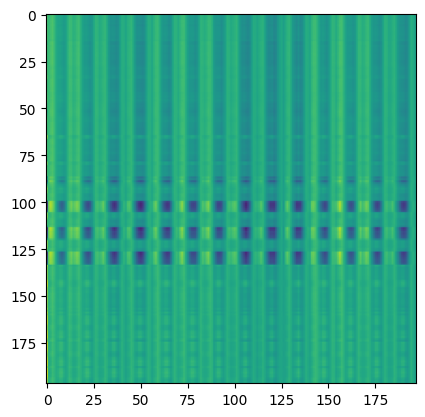

In [20]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

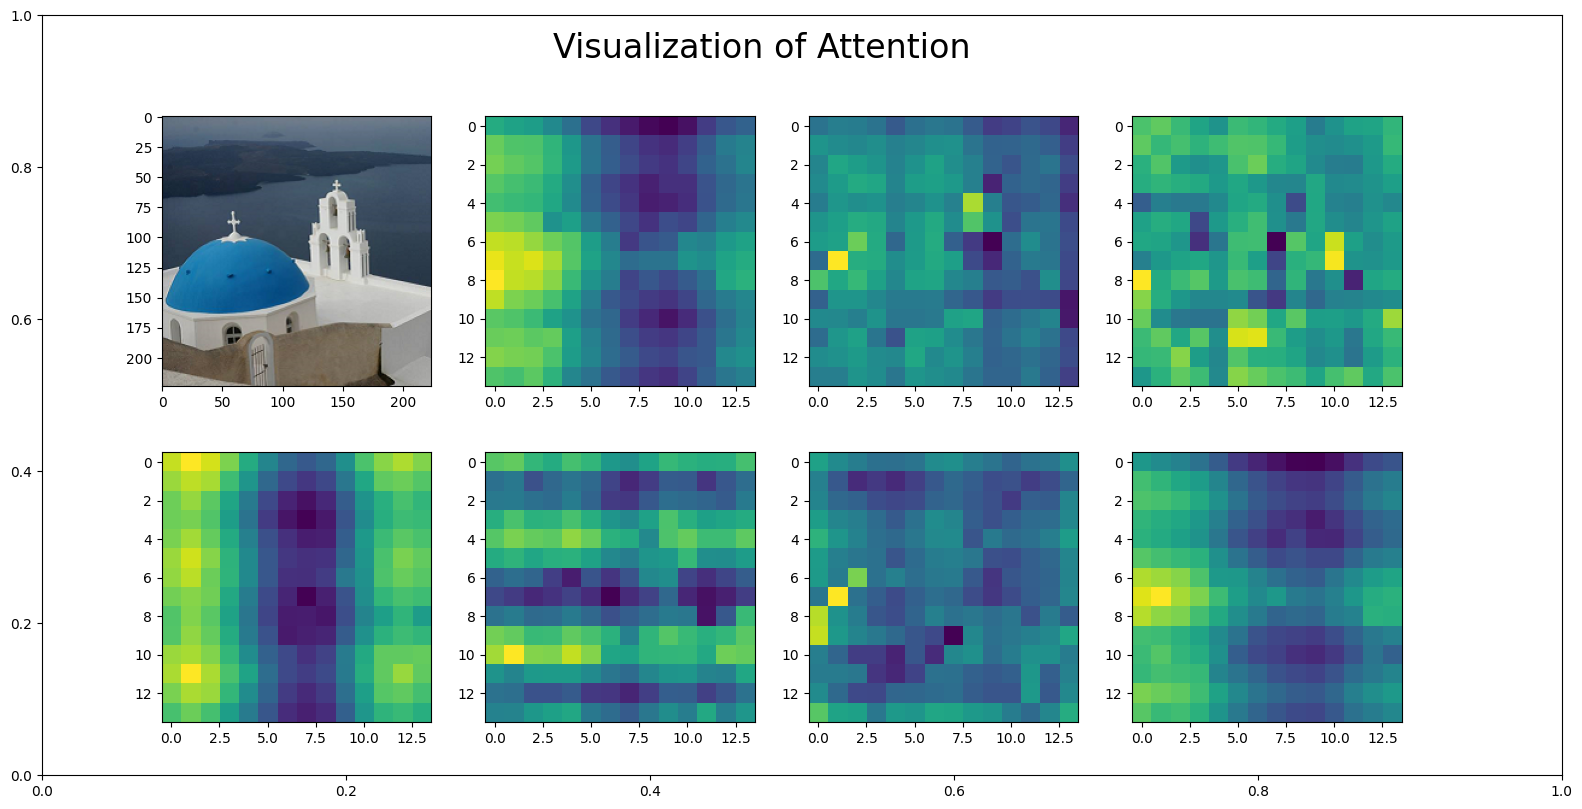

In [22]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
# Define the rect variable for axes
rect = [0.05, 0.05, 0.95, 0.95]
fig.add_axes(rect)
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 497, label name = church, church_building



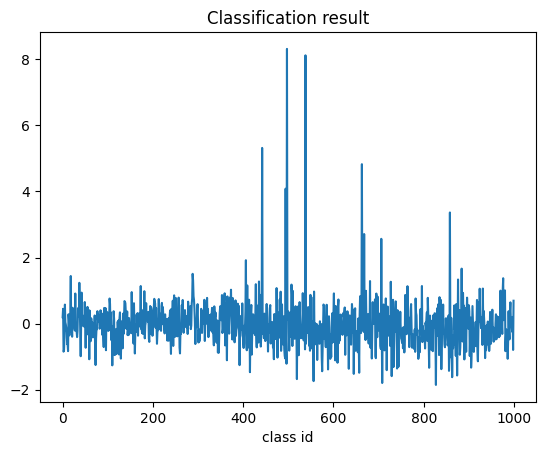

In [23]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))